# Training Deep Learning Models.

In this notebook the Dutch Dyslexia Programme (DDP) and ePodium dataset are used to train a deep neural network model.
The model is trained to predict the age and risk of dyslexia.
The input data consists of averaged epochs of the EEG data.

+ In section 1. [Prepare Dataset](#1mt) ...
+ In section 2. [Deep Learning](#2mt) ...

It is recommended to run this notebook with CUDA enabled with a dedicated graphics card to speed-up the training.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import local_paths
from functions import processing, display_helper, data_io
from functions.epodium import Epodium
from functions.ddp import DDP
#from functions.train_and_predict import EpodiumSequence, DDPSequence

from models import transformer
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

<br>



---
<a id='1mt'></a>
## 1. Prepare Dataset

__input dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ Binary: At risk of dyslexia
+ Regressive: Age, Vocabulary



In [2]:
# Choose dataset: "epodium" "ddp"
dataset_name = "ddp"

if dataset_name == "epodium":
    dataset = Epodium()    
    epochs_directory = local_paths.ePod_epochs
    event_directory = local_paths.ePod_epochs_events
    
    epod_labels = dataset.create_labels(local_paths.ePod_metadata)
    print(f"The available labels are:\n {list(epod_labels.columns)}")

elif dataset_name == "ddp":
    dataset = DDP()
    epochs_directory = local_paths.DDP_epochs
    event_directory = local_paths.DDP_epochs_events
    
    directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
    ddp_labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)
    print(f"The available labels are:\n {list(ddp_labels.columns)}") 

The available labels are:
 ['filename', 'participant', 'age_group', 'age_days']


#### Split processed epochs* into train and test sequence.

    *In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. In the context of deep learning, *epochs* are iterations over the entire training dataset.

First choose which processed data to use

In [3]:
experiment_list = processing.valid_experiments(dataset, event_directory, min_standards=180, min_deviants=80)

if dataset_name == "ddp":
    experiment_list = list(set(experiment_list)-set(dataset.wrong_channels_experiments))
    print(f"{len(dataset.wrong_channels_experiments)} experiments have incorrect channels.")
    
experiments_train, experiments_test = dataset.split_train_test_datasets(experiment_list)

Analyzed: 1057 bad: 238
819 experiments have enough epochs for analysis.
109 experiments have incorrect channels.
The dataset is split up into 553 train and 157 test experiments


#### Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [20]:
from tensorflow.keras.utils import Sequence
import random

class DDPSequence(Sequence):
    """
    An Iterator Sequence class as input to feed the model.
    The next value is given from the __getitem__ function.
    For more information on Sequences, go to:
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

    self.labels contains:  ['filename', 'participant', 'age_group', 'age_days']
    """    

    def __init__(self, experiments, target_labels, epochs_directory, n_experiments_batch=8,
                 n_instances_per_experiment=4, n_trials_averaged=30, gaussian_noise=0):
        self.experiments = experiments
        self.labels = target_labels
        self.epochs_directory = epochs_directory
        
        self.n_experiments_batch = n_experiments_batch
        self.instances = n_instances_per_experiment
        self.n_trials_averaged = n_trials_averaged
        self.gaussian_noise = gaussian_noise


    # The number of experiments in the entire dataset.
    def __len__(self):
        return int(np.ceil(len(self.experiments)/self.n_experiments_batch))

    def __getitem__(self, index, verbose=False):        
        x_batch = []
        y_batch = []
        
        #print(self.labels)

        for i in range(self.n_experiments_batch):

            # Set participant
            experiment_index = (index * self.n_experiments_batch + i) % len(self.experiments)
            experiment = self.experiments[experiment_index]
                        
            participant = experiment.split("_")[0]
            age_group = experiment.split("_")[1]
                        
            experiment_labels = self.labels.loc[(self.labels['participant']==float(participant))
                                                & (self.labels['age_group']==int(age_group))]

            if(verbose):
                print(experiment)
                
            # Load .fif file
            path_epochs = os.path.join(epochs_directory, experiment + "_epo.fif")
            epochs = mne.read_epochs(path_epochs, verbose=0)
            
            # A data instance is created for each condition
            for j in range(self.instances):
                
                standard_data = epochs["standard"].get_data()
                                
                # Create standardised ERP from averaging 'n_trials_averaged' trials.
                trial_indexes_standards = np.random.choice(standard_data.shape[0], self.n_trials_averaged, replace=False)
                evoked_standard = np.mean(standard_data[trial_indexes_standards,:,:], axis=0)
                
                evoked_standard += np.random.normal(0, self.gaussian_noise, evoked_standard.shape)
                # Divide by standard deviation to make the range of signals more similar:
                evoked_standard_std = evoked_standard/evoked_standard.std()
                
                x_batch.append(evoked_standard_std)
                y_batch.append(experiment_labels["age_days"].iloc[0])


        # Shuffle batch
        shuffle_batch = list(zip(x_batch, y_batch))
        random.shuffle(shuffle_batch)
        x_batch, y_batch = zip(*shuffle_batch)

        return np.array(x_batch), np.array(y_batch)

In [25]:
if dataset_name == "epodium":
    train_sequence = EpodiumSequence(experiments_train, epod_labels, epochs_directory, n_experiments_batch=1, gaussian_noise=1e-6)
    test_sequence = EpodiumSequence(experiments_test, epod_labels, epochs_directory, n_experiments_batch=1)
    
if dataset_name == "ddp":
    train_sequence = DDPSequence(experiments_train, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4, gaussian_noise=1e-6)
    test_sequence = DDPSequence(experiments_test, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4)

#### Visualise data instance

During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s.

154_23
162_11
491_11
177_11
714_41
9_11
114_23
36_29
The shape of one data instance is (26, 501)
In this experiment the age of the participant is 677 days:


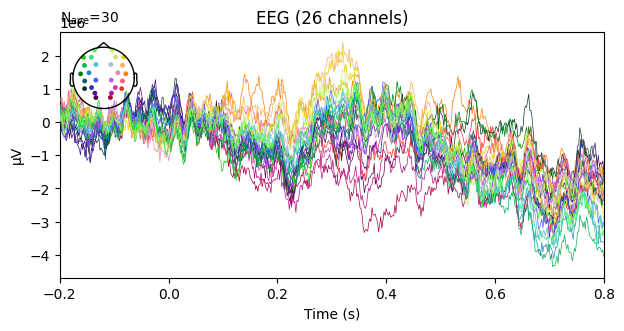

In [28]:
x, y = train_sequence.__getitem__(1, True)
print(f"The shape of one data instance is {x[0].shape}")

index = 31
print(f"In this experiment the age of the participant is {int(y[index])} days:")
display_helper.plot_array_as_evoked(x[index], dataset.channels_epod_ddp, frequency=500, n_trials=30)

<br>
<br>

---
<a id='2mt'></a>
## 2. Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.




#### Train model

In [30]:
model_name = "ddp_encoder_age_26ch_500hz"
model = encoder((26, 501), 1)
epochs = 100
learning_rate = 1e-4

# Paths to save model info
base_path = os.path.join(local_paths.models, model_name)

path_history = os.path.join(base_path, "history.npy")
path_model = os.path.join(base_path, "model")
path_testset = os.path.join(base_path, "testset.txt")
path_weights = os.path.join(base_path, "weights.h5")

if os.path.exists(path_model):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    # Save validation-set for future testing
    with open(path_testset, 'w') as f:
        for experiment in experiments_test:
            f.write(experiment + '\n')

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError()) # , metrics=[Precision(), BinaryAccuracy(), Recall()]

    # Fit model
    checkpointer = ModelCheckpoint(filepath=path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.7, verbose=1) # add to callbacks if uncomment
    history = model.fit(x=train_sequence, validation_data=test_sequence, epochs=epochs, callbacks=[checkpointer])

    np.save(path_history, history.history)
    model.save(path_model)

2022-10-17 21:51:37.486786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 21:51:37.530628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 21:51:37.530908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 21:51:37.534283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Create model: ddp_encoder_age_26ch_500hz
Epoch 1/100


2022-10-17 21:51:59.752577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-17 21:52:02.782644: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


70/70 [==============================] - ETA: 0s - loss: 690560.1250 
Epoch 1: val_loss improved from inf to 705110.37500, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz/weights.h5
70/70 [==============================] - 987s 14s/step - loss: 690560.1250 - val_loss: 705110.3750
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 676480.8125
Epoch 2: val_loss improved from 705110.37500 to 691048.18750, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz/weights.h5
70/70 [==============================] - 705s 10s/step - loss: 676480.8125 - val_loss: 691048.1875
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 658986.1875
Epoch 3: val_loss improved from 691048.18750 to 672251.43750, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz/weights.h5
70/70 [==============================] - 686s 10s/step - 

INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz/model/assets


INFO:tensorflow:Assets written to: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz/model/assets


#### Show Training History

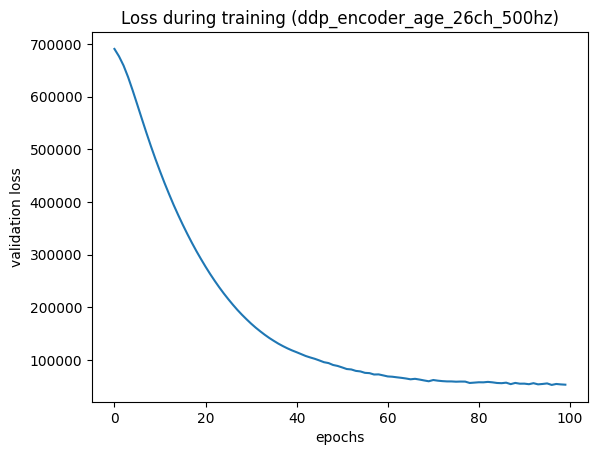

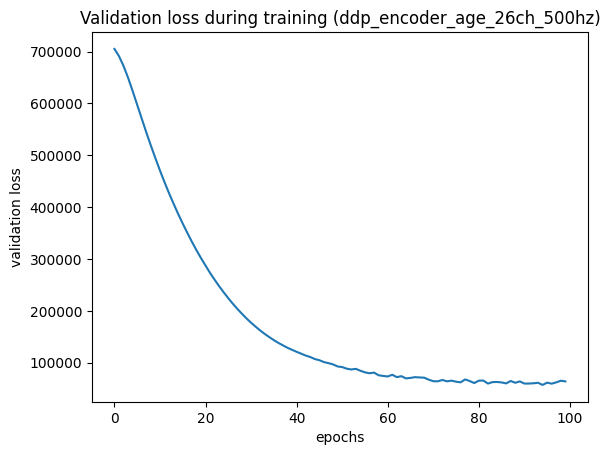

In [31]:
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['loss'], xlabel="epochs", ylabel="validation loss", title=f"Loss during training ({model_name})")
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['val_loss'], xlabel="epochs", ylabel="validation loss", title=f"Validation loss during training ({model_name})")